In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 17 14:48:31 2023

@author: dinglin
"""

import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from itertools import count
import random
import math

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
from collections import namedtuple, deque
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
class QCNN(nn.Module):
    def __init__(self, length, width, n_actions):
        super(QCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)  # Adjust this size as needed
        self.fc2 = nn.Linear(256, n_actions)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class DQL():
    def __init__(self, n_observations, n_actions):
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        
    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        with torch.no_grad():
            max_item = self.policy_net(state).max(1)
            max_action, max_q = max_item[1].view(1, 1), max_item[0].view(1, 1)
        if sample > eps_threshold:
            return max_action, max_q
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), max_q
        
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
def smoothing_plot(rewards, window = 99, save = False):
    # Sample rewards data (replace this with your actual rewards)
    episodes = list(range(1, len(rewards)+1))

    # Apply a smoothing filter (Savitzky-Golay filter) to the rewards
    smoothed_rewards = savgol_filter(rewards, window, 3)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, label='Original Rewards', color='lightgray', alpha=0.7)
    plt.plot(episodes, smoothed_rewards, label='Smoothed Rewards', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode with Smoothing')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig("rewards.pdf")
    plt.show()
    
def q_plot(qs, save = False):
    episodes = list(range(1, len(qs)+1))
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, qs, label='Max Q Values', color='blue', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Q Value')
    plt.title('Max Q Value per Episode')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig("rewards.pdf")
    plt.show()

In [7]:
num_episodes = 3000
LR = 1e-4
EPS_END = 0.05
EPS_START = 0.9
EPS_DECAY = 1000
BATCH_SIZE = 128
TAU = 0.005
GAMMA = 0.95
env = gym.make("CartPole-v0")

RL_cp = DQL(4,2)

all_rewards = []
all_q = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = []
    episode_q = []
    for t in count():
        action, q = RL_cp.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward.append(reward)
        episode_q.append(np.float64(q))
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        RL_cp.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        RL_cp.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = RL_cp.target_net.state_dict()
        policy_net_state_dict = RL_cp.policy_net.state_dict()
        if t%10 == 9:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            RL_cp.target_net.load_state_dict(target_net_state_dict)

        if done:
            #episode_durations.append(t + 1)
            #plot_durations()
            all_q.append(np.mean(episode_q))
            all_rewards.append(sum(episode_reward))
            if i_episode % 20 == 0:
                print('Episode: {}'.format(i_episode),
                    'Reward: {:.1f}'.format(np.mean(all_rewards[-10:])),
                    'Max Q: {:.2f}'.format(np.mean(episode_q)))
            break

/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Reward: 12.0 Max Q: 0.10
Episode: 20 Reward: 18.0 Max Q: 1.20
Episode: 40 Reward: 14.2 Max Q: 1.09
Episode: 60 Reward: 12.4 Max Q: 1.09
Episode: 80 Reward: 11.8 Max Q: 1.13
Episode: 100 Reward: 11.1 Max Q: 1.15
Episode: 120 Reward: 11.4 Max Q: 1.19
Episode: 140 Reward: 10.7 Max Q: 1.14
Episode: 160 Reward: 10.8 Max Q: 1.25
Episode: 180 Reward: 9.3 Max Q: 1.25
Episode: 200 Reward: 9.4 Max Q: 1.26
Episode: 220 Reward: 10.2 Max Q: 1.29
Episode: 240 Reward: 9.6 Max Q: 1.33
Episode: 260 Reward: 9.7 Max Q: 1.33
Episode: 280 Reward: 9.9 Max Q: 1.35
Episode: 300 Reward: 9.5 Max Q: 1.39
Episode: 320 Reward: 10.0 Max Q: 1.41
Episode: 340 Reward: 9.7 Max Q: 1.45
Episode: 360 Reward: 9.5 Max Q: 1.46
Episode: 380 Reward: 9.9 Max Q: 1.50
Episode: 400 Reward: 9.5 Max Q: 1.52
Episode: 420 Reward: 10.0 Max Q: 1.55
Episode: 440 Reward: 10.0 Max Q: 1.58
Episode: 460 Reward: 9.4 Max Q: 1.60
Episode: 480 Reward: 9.8 Max Q: 1.64
Episode: 500 Reward: 10.0 Max Q: 1.63
Episode: 520 Reward: 9.5 Max Q

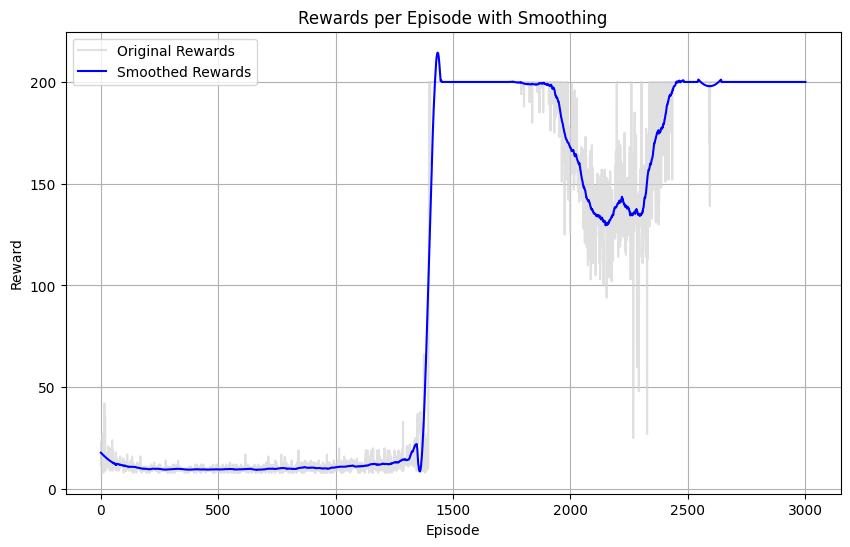

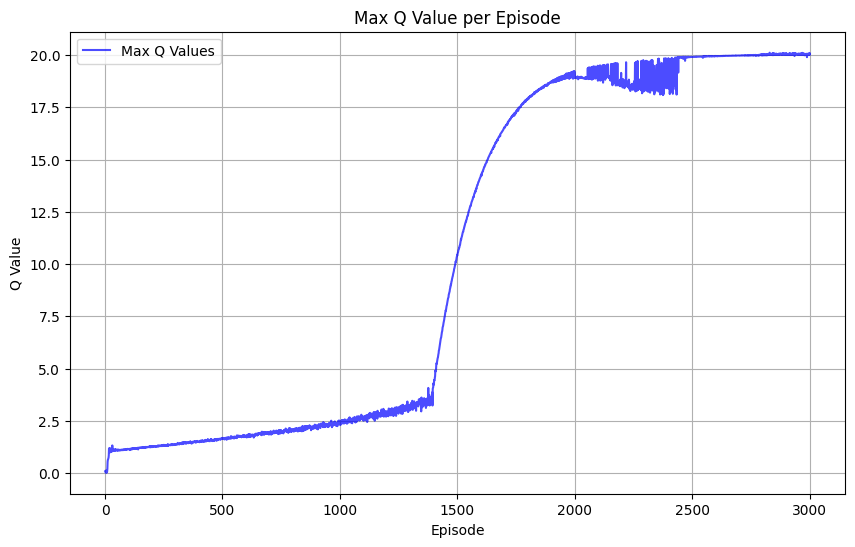

In [8]:
smoothing_plot(all_rewards)
q_plot(all_q)

In [9]:
RL_cp.target_net.eval()
RL_cp.policy_net.eval()

all_rewards = []

for i_episode in range(500):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = []
    for t in count():
        action, q = RL_cp.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward.append(reward)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        RL_cp.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        if done:
            all_rewards.append(sum(episode_reward))
            break
            


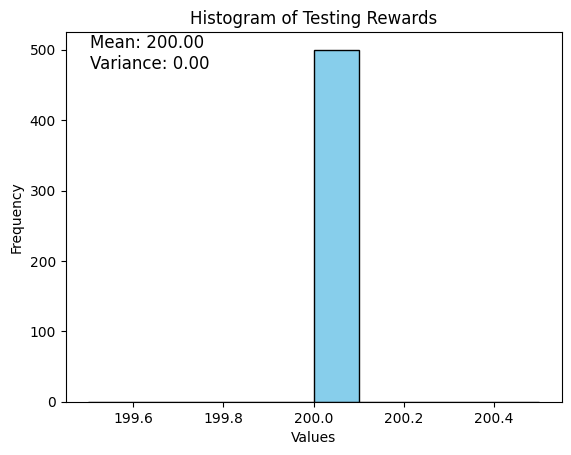

In [10]:
# Create a histogram
plt.hist(all_rewards, bins=10, color='skyblue', edgecolor='black')

# Calculate mean and variance
mean_val = np.mean(all_rewards)
variance_val = np.var(all_rewards)

# Add text annotation to the upper-left corner
plt.text(0.05, 0.9, f'Mean: {mean_val:.2f}\nVariance: {variance_val:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Customize the plot (optional)
plt.title('Histogram of Testing Rewards')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## Part II: Ms Pacman Simulation

In [1]:
mspacman_color = 210 + 164 + 74
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    img.reshape(88, 80, 1)
    return img.reshape(-1)

In [ ]:
num_episodes = 3000
LR = 1e-4
EPS_END = 0.05
EPS_START = 0.9
EPS_DECAY = 1000
BATCH_SIZE = 128
TAU = 0.005
GAMMA = 0.99
env = gym.make("MsPacman-v0")

RL_mp = DQL(7040,9)

all_rewards = []
all_q = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    episode_reward = []
    episode_q = []
    for t in count():
        state = preprocess_observation(state)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action, q = RL_mp.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward.append(reward)
        episode_q.append(np.float64(q))
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = preprocess_observation(observation)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        RL_mp.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = observation

        # Perform one step of the optimization (on the policy network)
        RL_mp.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = RL_mp.target_net.state_dict()
        policy_net_state_dict = RL_mp.policy_net.state_dict()
        if t%10 == 9:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            RL_mp.target_net.load_state_dict(target_net_state_dict)

        if done:
            #episode_durations.append(t + 1)
            #plot_durations()
            all_q.append(np.mean(episode_q))
            all_rewards.append(sum(episode_reward))
            if i_episode % 10 == 0:
                print('Episode: {}'.format(i_episode),
                    'Reward: {:.1f}'.format(np.mean(all_rewards[-10:])),
                    'Max Q: {:.2f}'.format(np.mean(episode_q)))
            # save results
            if i_episode % 100 == 0:
                np.save('./rewards.npy', all_rewards)
                np.save('./qs.npy', all_q)
            # save model
            if i_episode % 200 == 0:
                model_file_name = f"episode_{i_episode}.pth"
                torch.save(RL_mp.policy_net.state_dict(), '/nfs/home/dxk9547/iems469/assignment1/model/'+model_file_name)
            break

Episode: 0 Reward: 130.0 Max Q: 8.68
Episode: 10 Reward: 410.0 Max Q: 7.35
Episode: 20 Reward: 498.0 Max Q: 8.59
Episode: 30 Reward: 476.0 Max Q: 9.00
Episode: 40 Reward: 516.0 Max Q: 9.25
Episode: 50 Reward: 477.0 Max Q: 9.38
Episode: 60 Reward: 591.0 Max Q: 9.42
Episode: 70 Reward: 676.0 Max Q: 9.73
Episode: 80 Reward: 579.0 Max Q: 9.27
Episode: 90 Reward: 1002.0 Max Q: 9.72
Episode: 100 Reward: 425.0 Max Q: 9.52
Episode: 110 Reward: 694.0 Max Q: 10.26
Episode: 120 Reward: 882.0 Max Q: 11.84
Episode: 130 Reward: 752.0 Max Q: 10.23
Episode: 140 Reward: 691.0 Max Q: 12.03
Episode: 150 Reward: 708.0 Max Q: 14.60
Episode: 160 Reward: 927.0 Max Q: 12.28
Episode: 170 Reward: 1037.0 Max Q: 14.07
Episode: 180 Reward: 633.0 Max Q: 17.26
Episode: 190 Reward: 760.0 Max Q: 13.08
Episode: 200 Reward: 702.0 Max Q: 18.71
Episode: 210 Reward: 936.0 Max Q: 30.65
Episode: 220 Reward: 644.0 Max Q: 33.93
Episode: 230 Reward: 618.0 Max Q: 20.74
Episode: 240 Reward: 775.0 Max Q: 13.63
Episode: 250 Reward:

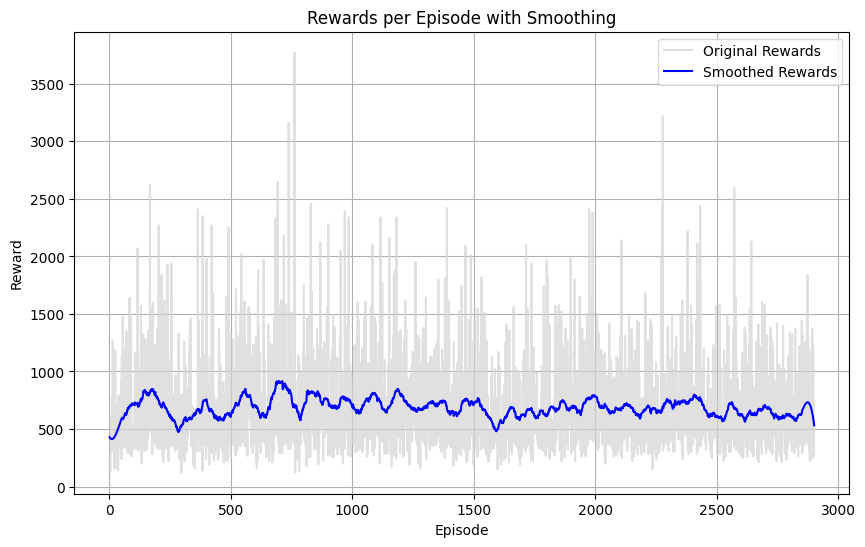

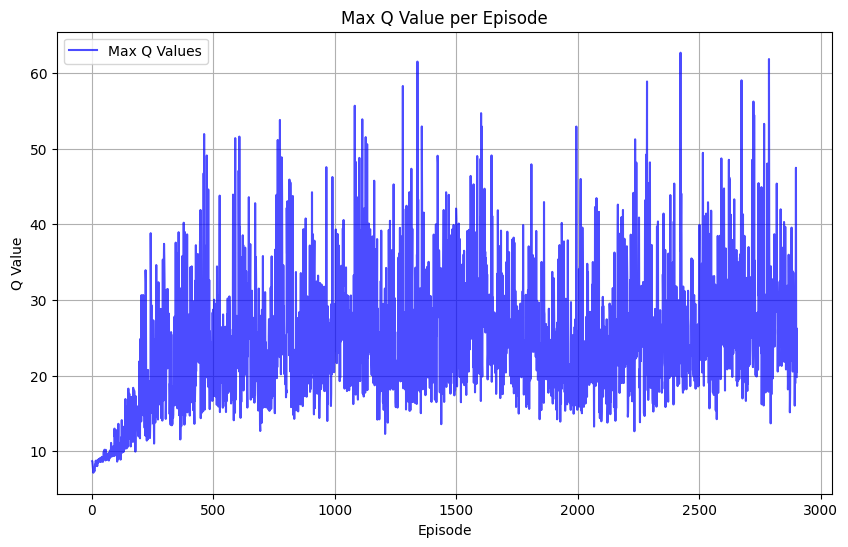

In [5]:
import numpy as np
all_rewards = np.load("./rewards.npy")
all_q = np.load("./qs.npy")
smoothing_plot(all_rewards)
q_plot(all_q)

In [12]:
num_episodes = 3000
LR = 1e-4
EPS_END = 0.05
EPS_START = 0.9
EPS_DECAY = 1000
BATCH_SIZE = 128
TAU = 0.005
GAMMA = 0.99
env = gym.make("MsPacman-v0")

RL_mp = DQL(7040,9)
RL_mp.target_net.load_state_dict(torch.load('/nfs/home/dxk9547/iems469/assignment1/model/episode_2800.pth'))
RL_mp.policy_net.load_state_dict(torch.load('/nfs/home/dxk9547/iems469/assignment1/model/episode_2800.pth'))
RL_mp.target_net.eval()
RL_mp.policy_net.eval()

all_rewards = []

for i_episode in range(500):
    # Initialize the environment and get it's state
    observation, info = env.reset()
    episode_reward = []
    for t in count():
        state = preprocess_observation(observation)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action, q = RL_mp.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward.append(reward)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = preprocess_observation(observation)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        RL_mp.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        if done:
            all_rewards.append(sum(episode_reward))
            break

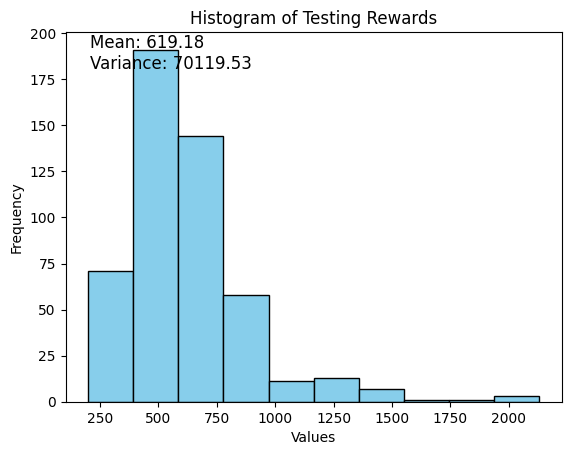

In [13]:
# Create a histogram
plt.hist(all_rewards, bins=10, color='skyblue', edgecolor='black')

# Calculate mean and variance
mean_val = np.mean(all_rewards)
variance_val = np.var(all_rewards)

# Add text annotation to the upper-left corner
plt.text(0.05, 0.9, f'Mean: {mean_val:.2f}\nVariance: {variance_val:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Customize the plot (optional)
plt.title('Histogram of Testing Rewards')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## CNN as Q-Network

In [4]:
mspacman_color = 210 + 164 + 74
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(1, 88, 80)

In [5]:
class QCNN(nn.Module):
    def __init__(self, length, width, n_actions):
        super(QCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 6, 512)
        self.fc2 = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class DQL():
    def __init__(self, n_observations, n_actions):
        if type(n_observations) == list:
            self.policy_net = QCNN(n_observations[0], n_observations[1], n_actions).to(device)
            self.target_net = QCNN(n_observations[0], n_observations[1], n_actions).to(device)
        else:
            self.policy_net = DQN(n_observations, n_actions).to(device)
            self.target_net = DQN(n_observations, n_actions).to(device)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        
    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        with torch.no_grad():
            max_item = self.policy_net(state).max(1)
            max_action, max_q = max_item[1].view(1, 1), max_item[0].view(1, 1)
        if sample > eps_threshold:
            return max_action, max_q
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), max_q
        
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
num_episodes = 3000
LR = 1e-4
EPS_END = 0.05
EPS_START = 0.9
EPS_DECAY = 1000
BATCH_SIZE = 128
TAU = 0.005
GAMMA = 0.99
mspacman_color = 210 + 164 + 74
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(1, 88, 80)

RL_mp = DQL([88, 80], 9)
env = gym.make("MsPacman-v0")
all_rewards = []
all_q = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    observation, info = env.reset()
    state = preprocess_observation(observation)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = []
    episode_q = []
    for t in count():
        action, q = RL_mp.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward.append(reward)
        episode_q.append(np.float64(q))
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            observation = preprocess_observation(observation)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        RL_mp.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        RL_mp.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = RL_mp.target_net.state_dict()
        policy_net_state_dict = RL_mp.policy_net.state_dict()
        if t%10 == 9:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            RL_mp.target_net.load_state_dict(target_net_state_dict)

        if done:
            #episode_durations.append(t + 1)
            #plot_durations()
            all_q.append(np.mean(episode_q))
            all_rewards.append(sum(episode_reward))
            if i_episode % 10 == 0:
                np.save("./rewards.npy", all_rewards)
                np.save("./qs.npy", episode_q)
            if i_episode % 20 == 0:
                print('Episode: {}'.format(i_episode),
                    'Reward: {:.1f}'.format(np.mean(all_rewards[-10:])),
                    'Max Q: {:.2f}'.format(np.mean(episode_q)))
            break

/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Episode: 0 Reward: 160.0 Max Q: 0.99
Episode: 20 Reward: 369.0 Max Q: 7.19
Episode: 40 Reward: 530.0 Max Q: 11.81
Episode: 60 Reward: 571.0 Max Q: 29.37
Episode: 80 Reward: 526.0 Max Q: 36.95
Episode: 100 Reward: 736.0 Max Q: 45.25
Episode: 120 Reward: 633.0 Max Q: 52.75
Episode: 140 Reward: 527.0 Max Q: 53.59
Episode: 160 Reward: 698.0 Max Q: 62.31
Episode: 180 Reward: 684.0 Max Q: 91.81
Episode: 200 Reward: 840.0 Max Q: 72.13
Episode: 220 Reward: 623.0 Max Q: 68.43
Episode: 240 Reward: 742.0 Max Q: 85.44
Episode: 260 Reward: 773.0 Max Q: 78.32
Episode: 280 Reward: 619.0 Max Q: 111.65


In [ ]:
all_rewards = np.load("./rewards.npy")[0:1000]
all_q = np.load("./qs.npy")
smoothing_plot(all_rewards)

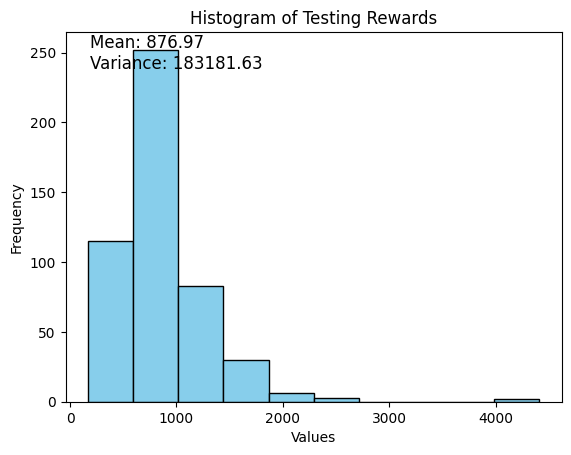

In [1]:
import matplotlib.pyplot as plt
import numpy as np

all_rewards = np.load("./rewards.npy")[2500:3000]
# Create a histogram
plt.hist(all_rewards, bins=10, color='skyblue', edgecolor='black')

# Calculate mean and variance
mean_val = np.mean(all_rewards)
variance_val = np.var(all_rewards)

# Add text annotation to the upper-left corner
plt.text(0.05, 0.9, f'Mean: {mean_val:.2f}\nVariance: {variance_val:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Customize the plot (optional)
plt.title('Histogram of Testing Rewards')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()